In [ ]:
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import glob
import os
from IPython.core.display import Image
from IPython.display import Image as DisplayImage
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KDTree

# Caminho do arquivo
caminho_zip = '/content/drive/MyDrive/dataset_LiDAR/KITTI-Sequence.zip'

# Extração do arquivo .zip para pasta pasta nomeada como dados
with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
  for nome_arquivo in zip_ref.namelist():
    if nome_arquivo.endswith('/'):    # Usado para ignorar diretórios
            continue
    zip_ref.extract(nome_arquivo, '/content/drive/MyDrive/dataset_LiDAR/dados')

# Diretório com as pasta que contém os scans
caminho = '/content/drive/MyDrive/dataset_LiDAR/dados'

Scan 0
Scan 1
Scan 2
Scan 3
Scan 4
Scan 5
Scan 6
Scan 7
Scan 8
Scan 9
Scan 10
Scan 11
Scan 12
Scan 13
Scan 14
Scan 15
Scan 16
Scan 17
Scan 18
Scan 19
Scan 20
Scan 21
Scan 22
Scan 23
Scan 24
Scan 25
Scan 26
Scan 27
Scan 28
Scan 29


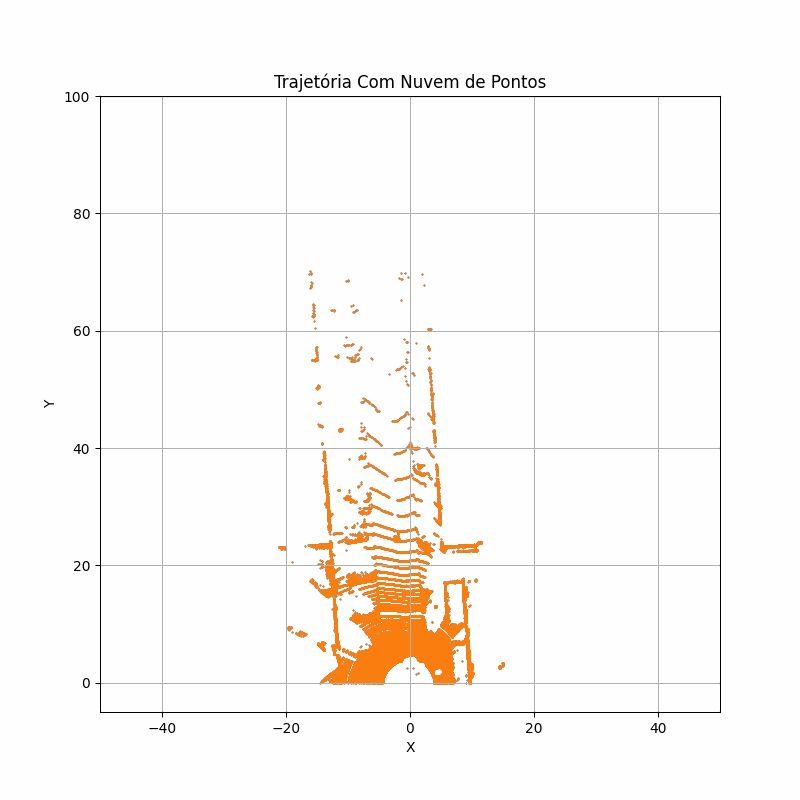

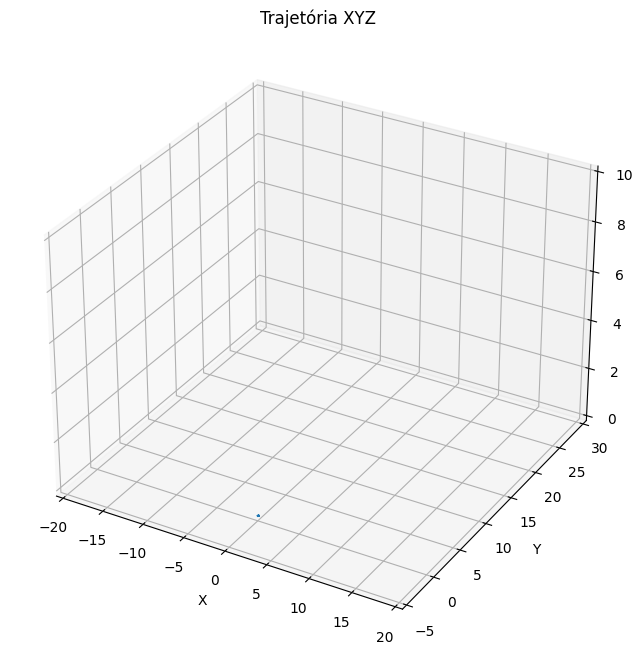

In [ ]:
def carregar_points_cloud(caminho):
    """
    Carrega nuvem de pontos e salva resultado em matriz numpy.

    Parâmetros
    ----------
    caminho: Caminho para a pasta com os dados

    Retornos
    --------
    xyz: Matrizez com os pontos da nuvem (x, y, z)

    """

    scans = []
    coordenadas = []

    for diretorio_atual, subdiretorios, arquivos in os.walk(caminho):
        for arquivo in arquivos:
            with open(os.path.join(diretorio_atual, arquivo), "r") as dados:
                linhas = dados.readlines()
                for linha in linhas:
                    if linha.startswith("v "):
                        eixo = linha.split()
                        x, y, z = float(eixo[1]), float(eixo[2]), float(eixo[3])
                        coordenadas.append([x, y, z])
                scans.append(np.array(coordenadas))
    return scans


def icp(scan, scan_referencia, max_iteracoes=50, tolerancia=1e-6):
    scan_movido = scan.copy()
    # Itera várias vezes para encontrar a melhor transformação que alinha os pontos
    for i in range(max_iteracoes):
        # Seleciona os pontos vizinhos mais próximos
        scan_referencia_correspondente = encontrar_scan_referencia_correspondente(scan_movido, scan_referencia)
        # Verifica se existem pontos vizinhos mais próximos
        if len(scan_referencia_correspondente) == 0:
            break
        # Estima a transformação que melhor alinha os pontos vizinhos mais próximos
        R, t, transformacao = calcular_transformacao(scan, scan_referencia_correspondente)
        # Aplica a transformação à nuvem de pontos
        scan_movido = np.dot(R, scan) + t
        # Erro médio quadrático
        erro_medio_quadratico = np.sum(
            np.sqrt(np.sum((np.dot(R, scan) + t - scan_referencia_correspondente) ** 2, axis=0)))
        if erro_medio_quadratico < tolerancia:
            break
    return R, t, transformacao

# Usa KD Tree que é eficiente para encontrar os pontos vizinhos mais próximos
def encontrar_scan_referencia_correspondente(scan, scan_referencia):
    arvore = KDTree(scan_referencia.T, metric='euclidean')
    indices = arvore.query(scan.T, k=1, return_distance=False).reshape(scan.shape[1])
    scan_referencia_correspondente = scan_referencia[:, indices]
    return scan_referencia_correspondente


def calcular_centroide(pontos):
    return np.mean(pontos, axis=1).reshape((3, 1))

# Estima a matriz de rotação (R) e o vetor de translação (t) que melhor alinham os pontos correspondentes entre as duas nuvens de pontos
def calcular_transformacao(scan, scan_referencia_correspondente):
    # Calculando o centroide
    centroide_scan = calcular_centroide(scan)
    centroide_scan_referencia_correspondente = calcular_centroide(scan_referencia_correspondente)
    # Matriz de covariância cruzada
    H = np.dot(scan - centroide_scan, (scan_referencia_correspondente - centroide_scan_referencia_correspondente).T)
    # Decomposição da matriz H em três matrizes
    U, _, V = np.linalg.svd(H)
    # Matriz de rotação ideal
    R = np.dot(U, V)
    # Se a matriz de rotação não estiver orientada corretamente, ela é corrigida
    if np.linalg.det(R) < 0:
        V[2, :] *= -1
        R = np.dot(V.T, U.T)
    # Translação
    t = centroide_scan_referencia_correspondente - np.dot(R, centroide_scan)
    # Matriz de transformação, caso seja necessária
    transformacao = np.identity(4)
    transformacao[:3, :3] = R
    transformacao[:3, 3] = t.T
    return R, t, transformacao


def plotar_trajetoria_xyz(trajetoria):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Trajetória XYZ')
    ax.plot(trajetoria[:, 0], trajetoria[:, 1], trajetoria[:, 2])
    ax.set_xlim([-20, 20])
    ax.set_ylim([-5, 30])
    ax.set_zlim([0, 10])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.grid()
    plt.show()


def calcular_trajetoria(lista_R, lista_t):
    trajetoria = np.zeros((len(lista_t), 3))
    for i in range(len(lista_t)):
      # Multiplica a matriz de rotação pela trajetória atual e adiciona o vetor de translação
      trajetoria[i] = lista_R[i].dot(trajetoria[i]) + lista_t[i].T
    return trajetoria


def main():
    all_scans = carregar_points_cloud(caminho)
    lista_R = []
    lista_t = []

    for i in range(30):
        print(str(i))
        # Executa o ICP
        R, t, transformacao = icp(all_scans[i].T, all_scans[max(i - 1, 0)].T, max_iteracoes=50, tolerancia=1e-6)
        # Aplica a transformação a nuvem de pontos atual
        all_scans[i] = (np.dot(R, all_scans[i].T) + t).T

        lista_R.append(R)
        lista_t.append(t)

        fig = plt.figure(figsize=(8, 8))
        ax = fig.subplots()
        ax.set_title('Trajetória Com Nuvem de Pontos')
        ax.scatter(all_scans[i][:, 0], all_scans[i][:, 1], s=0.2, label='Scan')
        ax.scatter(all_scans[max(i - 1, 0)][:, 0], all_scans[max(i - 1, 0)][:, 1], s=0.2,
                   label='Scan de Referência')
        ax.set_xlim([-50, 50])
        ax.set_ylim([-5, 100])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.grid()
        plt.savefig('/content/drive/MyDrive/dataset_LiDAR/figuras/fig' + str(i) + '.png')
        plt.close()


    imgs = (Image.open(f) for f in sorted(glob.glob("/content/drive/MyDrive/dataset_LiDAR/figuras/fig*.png")))
    img = next(imgs)
    img.save("/content/drive/MyDrive/dataset_LiDAR/figuras/traj.gif", format='GIF', append_images=imgs, save_all=True, duration=200, loop=0)
    display_gif = DisplayImage(filename="/content/drive/MyDrive/dataset_LiDAR/figuras/traj.gif")
    display(display_gif)

    trajetoria = calcular_trajetoria(lista_R, lista_t)

    plotar_trajetoria_xyz(trajetoria)


if __name__ == '__main__':
    main()
